# Treasury Rate Time-Series Visualization

## Introduction

The Jupyter notebook automates the process of downloading Treasury rate data and displaying the past 10-year rate time-series data with a monthly timestep over the past 12 months. It consists of sections for installing necessary libraries such as pandas, matplotlib, and yfinance, downloading the Treasury rate data using yfinance, preprocessing the data for visualization, and creating a line plot to visualize the data. The notebook fulfills the prompt "/generate I want to automatically download Treasury rate and show the past 10-yr rate time-series data using monthly timestep for the past 12-month period."

## Requirements
yfinance

In [25]:
import streamlit as st
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

## Download Treasury rate data

In [26]:
# Download Treasury rate data from Yahoo Finance for the past 12 months with monthly timestep
#^IRX: 1-Year Eris SOFR Swap Futures,M (YIAH24.CBT)
#^FVX five year Treasury
#^TNX 10 year Treasury
#^TYX 30 year Treasury

treasury_rate_data = yf.download("^IRX ^FVX ^TNX ^TYX", start="2022-12-29", end=None)#, interval="1mo")

[*********************100%%**********************]  4 of 4 completed


In [27]:
# Display the downloaded Treasury rate data
df = treasury_rate_data["Adj Close"]
#df.info()
#print(df)

## Visualize the data

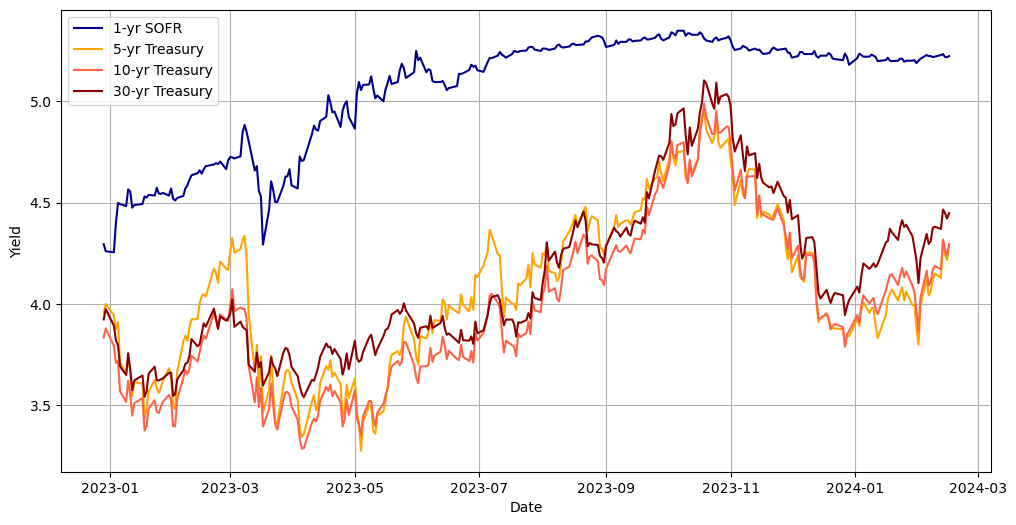

In [30]:
# Plotting the data
is_streamlit = False

if is_streamlit == True:
    # Streamlit application starts here
    st.title('Treasury Yield Tracker')
    
    # Plotting the data with Streamlit
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df['^IRX'], label='1-yr SOFR', color='darkblue')
    ax.plot(df.index, df['^FVX'], label='5-yr Treasury', color='orange')
    ax.plot(df.index, df['^TNX'], label='10-yr Treasury', color='tomato')
    ax.plot(df.index, df['^TYX'], label='30-yr Treasury', color='darkred')
    ax.set_xlabel('Date')
    ax.set_ylabel('Yield')
    ax.legend()
    ax.grid(True)
    
    # Use Streamlit's method to display the figure
    st.pyplot(fig)

else:
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['^IRX'], label='1-yr SOFR', color='darkblue')
    plt.plot(df.index, df['^FVX'], label='5-yr Treasury', color='orange')
    plt.plot(df.index, df['^TNX'], label='10-yr Treasury', color='tomato')
    plt.plot(df.index, df['^TYX'], label='30-yr Treasury', color='darkred')
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.legend()
    plt.grid(True)
    plt.show()

In [31]:
# Filter for quarter ends
quarter_end_data = df.resample('M').last()

# Rename column names
new_column_names = {'^IRX': '1-yr SOFR',
                    '^FVX': '5-yr Treasury',
                    '^TNX': '10-yr Treasury',
                    '^TYX': '30-yr Treasury'}

quarter_end_data = quarter_end_data.rename(columns = new_column_names)

# Rerder columns
desired_order = ['1-yr SOFR', '5-yr Treasury', '10-yr Treasury', '30-yr Treasury']

# Show the filtered DataFrame
if is_streamlit == True:
    st.subheader('Data Table')
    st.dataframe(quarter_end_data[desired_order])
else:
    print(quarter_end_data[desired_order])

Ticker      1-yr SOFR  5-yr Treasury  10-yr Treasury  30-yr Treasury
Date                                                                
2022-12-31      4.260          4.000           3.879           3.975
2023-01-31      4.570          3.638           3.529           3.661
2023-02-28      4.710          4.168           3.916           3.931
2023-03-31      4.585          3.611           3.494           3.689
2023-04-30      4.923          3.536           3.452           3.678
2023-05-31      5.248          3.743           3.637           3.856
2023-06-30      5.153          4.133           3.819           3.855
2023-07-31      5.248          4.179           3.959           4.019
2023-08-31      5.298          4.244           4.093           4.204
2023-09-30      5.300          4.606           4.573           4.711
2023-10-31      5.320          4.816           4.875           5.022
2023-11-30      5.238          4.298           4.352           4.513
2023-12-31      5.180          3.8